In [ ]:
## REMEMBER TO CREATE THE logs FOLDER TO STORE THE OUTPUT LOGS AND UPLOAD THE TINYSONG.CSV FILE !!!
## DO NOT FORGET !!!!

## logs2 in the folder is a storage of one complete runthrough of the model for all different combinations of learning rate and tau
## logs2 was run with 15 epochs and early stopping point 5; the numbers should not be too different

## Please note that this is a cleaned up version of the original notebook; some cells have been combined and others moved around
## The printed outputs may no longer match the non-executed cell statements

## The following cells help set up the model.

In [ ]:
import datasets
from datasets import load_dataset, DatasetDict
import transformers
from torch.utils.data import DataLoader
from dataclasses import dataclass
from random import randint
from typing import Any, Callable, Dict, List, NewType, Optional, Tuple, Union
from transformers.utils import PaddingStrategy
from transformers import PreTrainedTokenizerBase
import pandas as pd
import matplotlib.pyplot as plt

def tokenize_features(sample, tokenizer, features=None, max_token_len=None):
    if features is None:
        features = sample.keys()

    batch = {}
    for key, val in sample.items():
        batch[key] = f" [{key}] {val}"
        if key in features:
            batch[f"{key}.input_ids"] = tokenizer(
                batch[key],
                return_attention_mask=False,
                add_special_tokens=False,
                max_length=max_token_len,
                truncation=True
            )['input_ids']
    return batch

def concat_features(sample, out_config, tokenizer, max_token_len):
    batch = {}

    for config in out_config:
        features = config['input_features'] + config['trainable_features']

        tot_tokens = sum([len(sample[f"{f}.input_ids"]) for f in features])
        excessive_tokens = tot_tokens - max_token_len +1 # +1 for eos token
        if excessive_tokens>0:
            sample[f"input_ids.{config['feature_to_trunc']}"] = sample[f"{config['feature_to_trunc']}.input_ids"][:-excessive_tokens]
        if config['token_prepend']!="":
            token_prepend = f"{config['token_prepend']}."
        else:
            token_prepend = ""
        batch[f"{token_prepend}input_ids"] = []
        batch[f"{token_prepend}labels"] = []
        for f in config['input_features']:
            input_col = f"{token_prepend}input_ids"
            label_col = f"{token_prepend}labels"
            batch[input_col] += sample[f"{f}.input_ids"]
            batch[label_col] += [-100]*len(sample[f"{f}.input_ids"])

        for tf in config['trainable_features']:
            batch[input_col] += sample[f"{tf}.input_ids"]
            batch[label_col] += sample[f"{tf}.input_ids"]

        # Append eos token
        batch[input_col] += [tokenizer.eos_token_id]
        batch[label_col] += [tokenizer.eos_token_id]

        # Truncate at end
        batch[input_col] = batch[input_col][:max_token_len]
        batch[label_col] = batch[label_col][:max_token_len]

    return batch

def tokenize_and_concat(sample, tokenizer, out_config, max_token_len=256):
    batch = tokenize_features(sample,tokenizer, max_token_len=max_token_len-10) # -10 to leave room for other features
    batch = concat_features(batch, out_config, tokenizer=tokenizer, max_token_len=max_token_len)
    return batch


In [ ]:
@dataclass
class DataCollatorWithPaddingAndLabels:
    """
    Modified from the original DataCollatorWithPadding to handle labels and to send all other features to the batch without any processing.
    Data collator that will dynamically pad the inputs received.

    Args:
        tokenizer ([`PreTrainedTokenizer`] or [`PreTrainedTokenizerFast`]):
            The tokenizer used for encoding the data.
        padding (`bool`, `str` or [`~utils.PaddingStrategy`], *optional*, defaults to `True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:

            - `True` or `'longest'` (default): Pad to the longest sequence in the batch (or no padding if only a single
              sequence is provided).
            - `'max_length'`: Pad to a maximum length specified with the argument `max_length` or to the maximum
              acceptable input length for the model if that argument is not provided.
            - `False` or `'do_not_pad'`: No padding (i.e., can output a batch with sequences of different lengths).
        max_length (`int`, *optional*):
            Maximum length of the returned list and optionally padding length (see above).
        pad_to_multiple_of (`int`, *optional*):
            If set will pad the sequence to a multiple of the provided value.

            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
        return_tensors (`str`, *optional*, defaults to `"pt"`):
            The type of Tensor to return. Allowable values are "np", "pt" and "tf".
    """

    tokenizer : PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    return_tensors: str = "pt"

    def __call__(self, samples: Dict[str, List[Any]]) -> Dict[str, Any]:
        # convert into a dict with lists
        features_list = {key: [] for key in samples[0].keys()}
        for sample in samples:
            for key, val in sample.items():
                features_list[key].append(val)

        batch = {}
        for key, val in features_list.items():
            if "input_ids" in key:
                padded = self.tokenizer.pad(
                    {'input_ids' : val},
                    padding=self.padding,
                    max_length=self.max_length,
                    pad_to_multiple_of=self.pad_to_multiple_of,
                    return_tensors=self.return_tensors,
                    return_attention_mask=True
                )
                batch[key] = padded['input_ids']
                batch[key.replace("input_ids","attention_mask")] = padded['attention_mask']
            elif "labels" in key:
                batch[key] = self.tokenizer.pad(
                    {'input_ids' : val},
                    padding=self.padding,
                    max_length=self.max_length,
                    pad_to_multiple_of=self.pad_to_multiple_of,
                    return_tensors=self.return_tensors,
                    return_attention_mask=False
                )['input_ids']
            else:
                batch[key] = val
        return batch

In [ ]:
import csv
def load_songlyrics_dataset(tokenizer, max_token_len, min_token_length=10, num_tasks=6):
    """
    num_tasks = 6
    max_token_len=256
    min_token_length=10
    """

    raw = (pd.read_csv('tinysong.csv')
        .pipe(lambda df: df.dropna()) # drop nans
        .pipe(lambda df: df.reset_index(drop=True)) # reset index
        .pipe(lambda df: df.rename(columns={"emotion": "task", "text": "text"}))
        )

    # Group by task and create train and val datasets for each
    train_dfs = {}
    val_dfs = {}
    test_dfs = {}
    task_stats = {}


    for task, df in raw.groupby('task'):
        # 50% train, 25% val, 25% test
        train_df = df.sample(frac=0.5, random_state=42)
        temp_df = df.drop(train_df.index)
        val_df = temp_df.sample(frac=0.5, random_state=42)
        test_df = temp_df.drop(val_df.index)
        train_dfs[task], val_dfs[task], test_dfs[task] = train_df, val_df, test_df

        task_stats[task] = {
            'train_len' : len(train_df),
            'val_len' : len(val_df),
            'test_len' : len(test_df),
        }
        if len(train_dfs) == num_tasks:
            break
    # Concatenate all train and val datasets
    train_df = pd.concat(train_dfs.values()).reset_index(drop=True)
    val_df = pd.concat(val_dfs.values()).reset_index(drop=True)
    test_df = pd.concat(test_dfs.values()).reset_index(drop=True)

    # Convert into datasets format
    ds = datasets.DatasetDict({
        'train': datasets.Dataset.from_pandas(train_df),
        'valid': datasets.Dataset.from_pandas(val_df),
        'test': datasets.Dataset.from_pandas(test_df)
    })

    out_config = [
    {
        'token_prepend' : '',
        'input_features' : ['task'],
        'trainable_features' : ['text'],
        'feature_to_trunc' : 'text'
    },
    ]
    ds = ds.map(lambda sample: tokenize_and_concat(sample, tokenizer,out_config,max_token_len=max_token_len), num_proc=None)

    return ds, task_stats

def prepare_songlyrics_dataloaders(tokenizer, batch_size=4, max_token_len=256, num_tasks=6, *args, **kwargs):
    """
    batch_size=4
    max_token_len=256
    num_tasks=6
    """
    ds, task_stats = load_songlyrics_dataset(tokenizer, max_token_len=max_token_len, num_tasks=num_tasks)
    ds = ds.shuffle(seed=42)
    data_collate = DataCollatorWithPaddingAndLabels(tokenizer=tokenizer, max_length=max_token_len)
    dataloaders = {}
    for phase in ["train","valid","test"]:
        dataloaders[phase] = DataLoader(ds[phase], batch_size=batch_size, collate_fn=data_collate)
    return dataloaders, task_stats


In [ ]:
def build_graph_for_training_lengths():
        """
        # sample of task stats
        task_stats = {'anger': {'train_len': 490, 'val_len': 246, 'test_len': 245},
                      'fear': {'train_len': 126, 'val_len': 63, 'test_len': 63}, ...}
        # plot a histogram of the number of examples per task
        """
        # Extract task names and training lengths
        tasks = list(task_stats.keys())
        train_lengths = [stats['train_len'] for stats in task_stats.values()]

        # Create bar plot
        plt.figure(figsize=(10, 6))
        plt.bar(tasks, train_lengths, color='steelblue', edgecolor='black')
        plt.xlabel('Task', fontsize=14)
        plt.ylabel('Training Length', fontsize=14)
        plt.title('Training Length for each Task', fontsize=16)
        plt.xticks(rotation=90, fontsize=12)  # Rotate x-axis labels for better visibility
        plt.yticks(fontsize=12)
        plt.grid(True)

        # Save the plot as a PNG file with a transparent background
        # plt.savefig('training_lengths.png', transparent=True, bbox_inches='tight')

        plt.close()


In [ ]:
# tokenizer = transformers.AutoTokenizer.from_pretrained("facebook/opt-350m")
tokenizer = transformers.GPT2Tokenizer.from_pretrained('gpt2-medium')
tokenizer.pad_token_id = tokenizer.eos_token_id
dataloaders, task_stats = prepare_songlyrics_dataloaders(tokenizer, batch_size=32, max_token_len=256, num_tasks=6)
build_graph_for_training_lengths()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

Map:   0%|          | 0/2466 [00:00<?, ? examples/s]

Map:   0%|          | 0/1233 [00:00<?, ? examples/s]

Map:   0%|          | 0/1234 [00:00<?, ? examples/s]

## The following cells are finetuning and training the model based on varying learning rates and tau values. The logs will be saved in a folder called "logs". Be sure to create this folder in your directory before running the following cells.

In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from torch.optim import AdamW, SGD
from transformers import AutoModelForCausalLM, AutoTokenizer
import lightning as L
from accelerate import Accelerator
import torch
import numpy as np

In [ ]:
class LightningHier(L.LightningModule):
    """ PyTorch Lightning Model class for model training"""

    def __init__(
        self,
        tokenizer,
        model,
        task_stats,
        outputdir: str = "outputs",
        save_only_last_epoch: bool = False,
        learning_rate: float = 0.0001,
        accumulate_grad_batches: int = 1,
        weight_decay:  float = 0.0,
        reg_weight: float = 0.0,
        optim_type: bool = "joined_grad",
        *args, **kwargs
    ):
        """
        initiates a PyTorch Lightning Model
        """
        super().__init__()
        self.task_stats= task_stats
        self.tasks = list(task_stats.keys())
        self.model = model
        self.tokenizer = tokenizer
        self.outputdir = outputdir
        self.save_only_last_epoch = save_only_last_epoch
        self.learning_rate = learning_rate
        self.accumulate_grad_batches = accumulate_grad_batches
        self.weight_decay = weight_decay
        self.reg_weight = reg_weight
        self.optim_type = optim_type

    def forward(self, input_ids, attention_mask, labels=None, *args, **kwargs):
        """ forward step """
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
        )
        return output

    def compute_l2_norms_of_adapters(self):
        l2_norms = {}
        for key in self.tasks:
            l2_norms[f"l2/{key}"] = 0
            l2_norms[f"l2_from_base/{key}"] = 0
        l2_norms["l2/base"] = 0.0

        for base_key, val in self.model.named_parameters():
            if "base_adapter" in base_key:
                l2_norms["l2/base"] += torch.norm(self.model.get_parameter(base_key))

                for adapter in self.tasks:
                    adapter_key = base_key.replace("base_adapter", adapter)
                    # compute l2 norm of adapter
                    l2_norms[f"l2/{adapter}"] += torch.norm(self.model.get_parameter(adapter_key))
                    # compute l2 norm between base adapter and adapter
                    diff = torch.norm(self.model.get_parameter(base_key) - self.model.get_parameter(adapter_key))
                    l2_norms[f"l2_from_base/{adapter}"] += diff
        return l2_norms

    def step(self, batch, phase):
        batch_tasks = np.array(batch['task'])
        logs = {}
        loss_loglik_dict = {}
        for task in self.tasks:
            # task = self.tasks[0]
            current_task = (task == batch_tasks)
            if not current_task.any():
                continue
            # filter out current tasks if tensor or list
            batch_task = {key : val[current_task]
                          for key, val in batch.items()
                          if isinstance(val, torch.Tensor)}

            # Set adapter to relevant task except if global_only is True
            if self.optim_type == "global_only":
                self.model.set_adapter("base_adapter")
            elif self.optim_type == "joined_grad":
                self.model.set_adapter([task] + ["base_adapter"])
            elif self.optim_type == "regularized":
                self.model.set_adapter(task)
            output = self(
                input_ids = batch_task['input_ids'],
                attention_mask = batch_task['attention_mask'],
                labels=batch_task['labels'])

            loss_loglik_dict[task] = output['loss']

        ### hierarchical loss
        self.model.set_adapter(self.tasks + ["base_adapter"]) # Set all adapters to active again
        l2_norms = self.compute_l2_norms_of_adapters()

        if self.optim_type == "regularized":
            reg_loss = sum([val for key, val in l2_norms.items() if "l2_from_base" in key])
        elif self.optim_type == "joined_grad":
            reg_loss = sum([val for key, val in l2_norms.items() if ("l2/" in key) and (key != "l2/base")])

        # log reg losses:
        if phase=="train":
            self.log_dict(l2_norms, on_epoch=False, sync_dist=True, on_step=True)

        loss_loglik = sum([val*self.task_stats[task]['train_len'] for task, val in loss_loglik_dict.items()])
        if self.reg_weight>0:
            loss = loss_loglik + reg_loss*self.reg_weight
        else:
            loss = loss_loglik

        ## LOGGING
        for key, val in loss_loglik_dict.items():
            logs[f"{phase}_all/loglik/{key}"] = -val

        avg_loglik = -sum(loss_loglik_dict.values())/len(loss_loglik_dict)
        logs[f'{phase}/loglik'] = avg_loglik
        logs[f'{phase}/perplexity'] = torch.exp(-avg_loglik)
        # print('PERPLEXITY = ', torch.exp(-avg_loglik))

        logs[f'{phase}/loss'] = loss
        for key, val in logs.items():
            self.log(key, val, on_epoch=True, sync_dist=True if phase=="val" else False)

        return loss

    def training_step(self, batch, batch_idx):
        return self.step(batch, phase="train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, phase="val")

    def test_step(self, batch, batch_idx):
        return self.step(batch, phase="test")

    def configure_optimizers(self):
        """ configure optimizers """
        count_model_pars(self.model)
        return AdamW(self.parameters(), lr=self.learning_rate,weight_decay=self.weight_decay)


def count_model_pars(model):
    # count number of trainable parameters as share of total:
    num_pars, num_trainable = 0, 0
    for key, par in model.named_parameters():
        num_pars += par.numel()
        if par.requires_grad:
            num_trainable += par.numel()
    print(f"Model has {num_pars/1e6:.1f}m parameters of which {num_trainable/1e6:.1f}m are trainable ({num_trainable/num_pars*100:.2f}%)")
    return num_pars, num_trainable

def load_tokenizer(params):
    tokenizer = AutoTokenizer.from_pretrained(params['model_name'])
    tokenizer.pad_token = tokenizer.eos_token
    # tokenizer.padding_side ='right' # needed for lama as they pad left
    return tokenizer

def load_model(params, tokenizer, task_stats, checkpoint_path=None):
    # Load model given parameters in params
    device_index = Accelerator().process_index
    device_map = {"": device_index}
    model = AutoModelForCausalLM.from_pretrained(
        params['model_name'],
        trust_remote_code=True,
        load_in_8bit=params.get('load_in_8bit',False),
        load_in_4bit=params.get('load_in_4bit',False),
        device_map=device_map,
        )

    # Build adapters per task
    from peft import LoraConfig, TaskType, prepare_model_for_kbit_training
    lora_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        inference_mode=False,
        r=params['lora_dim'],
        lora_alpha=params['lora_alpha'],
        lora_dropout=params['lora_dropout'],
        target_modules=params['lora_target_modules']
        )

    model = prepare_model_for_kbit_training(model)
    # Add adapters
    model.add_adapter(lora_config, adapter_name="base_adapter")

    for task in task_stats.keys():
        model.add_adapter(lora_config, adapter_name=task)
        count_model_pars(model)

    # Set parameters in adapters to be equivalent to base_adapter
    for base_key, val in model.named_parameters():
        if "base_adapter" in base_key:
            for adapter in task_stats.keys():
                adapter_key = base_key.replace("base_adapter", adapter)
                model.get_parameter(adapter_key).data = model.get_parameter(base_key).data.detach().clone()
                # Add some noise to the adapters
                model.get_parameter(adapter_key).data += torch.randn_like(model.get_parameter(adapter_key).data) * 0.001

    if checkpoint_path:
        print("loading from checkpoint..")
        pl_model = LightningHier.load_from_checkpoint(checkpoint_path,
                                  tokenizer=tokenizer, model=model,
                                  task_stats=task_stats, **params)
        del model
        torch.cuda.empty_cache()
    else:
        pl_model = LightningHier(tokenizer=tokenizer, model=model, task_stats=task_stats, **params)
    return pl_model

def main(overwrite_params={}):
    """
    overwrite_params = {}
    """
    params = {
        'model_name': "gpt2",
        'max_token_length': 256,
        'batch_size' : 32,
        'load_in_8bit' : False,
        'num_tasks' : 6,
        'reg_weight' : 10.1, # this is the other parameter to change
        "optim_type" : "joined_grad", # global_only , regularized
        # LORA PARAMETERS
        'lora_dim' : 16,
        'lora_alpha' : 16,
        'lora_dropout' : 0.0,
        'lora_target_modules' : None,
        # OPTIM PARAMETERS
        'learning_rate' : 0.0001, # to change
        'weight_decay' : 0,
        'accumulate_grad_batches' : 1,
        'early_stopping_patience_epochs' : 5,
        'max_epochs' : 20,
        'precision': 32,
        'log_every_n_steps' : 10,
        'val_check_interval' : 1.0,
    }
    for key, val in overwrite_params.items():
        params[key] = val

    tokenizer = load_tokenizer(params)
    dataloaders, task_stats = prepare_songlyrics_dataloaders(tokenizer, **params)
    task_stats
    pl_model = load_model(params, task_stats=task_stats, tokenizer=tokenizer)

    callbacks = [
        L.pytorch.callbacks.TQDMProgressBar(refresh_rate=5),
        L.pytorch.callbacks.ModelCheckpoint(monitor="val/loglik", mode="max", save_top_k=1),
        ]

    if params['early_stopping_patience_epochs'] > 0:
        early_stop_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(
            monitor="val/loglik",
            min_delta=0.00,
            patience=params['early_stopping_patience_epochs'],
            verbose=True,
            mode="max",
        )
        callbacks.append(early_stop_callback)

    # prepare trainer
    print(params)
    trainer = L.Trainer(
        callbacks=callbacks,
        logger = L.pytorch.loggers.TensorBoardLogger("logs",name = f"reg:{params['reg_weight']}-lr:{params['learning_rate']}"),
        max_epochs=params['max_epochs'],
        devices=1,
        accelerator="gpu",
        accumulate_grad_batches=params['accumulate_grad_batches'],
        precision=params['precision'],
        val_check_interval=params['val_check_interval'],
        log_every_n_steps=params['log_every_n_steps']
    )

    trainer.fit(pl_model,
                train_dataloaders=dataloaders['train'],
                val_dataloaders=dataloaders['valid'])

    return trainer, pl_model

if __name__ == "__main__":
    values = [(0, 10 ** -4), (10 ** 0, 10 ** -5), (10 ** 1, 10 ** -4), (10 ** 2, 10 ** -3), (10 ** 3, 10 ** -2), (10 ** 4, 10 ** -1)]
    train_lst = []
    pl_model_lst = []

    for val in values:
        print(val)
        overwrite_params={"reg_weight" : val[0],
                          "learning_rate": val[1],
                          'early_stopping_patience_epochs' : 5,
                          'max_epochs' : 20}
        trainer, pl_model = main(overwrite_params)
        train_lst.append(trainer)
        pl_model_lst.append(pl_model)
        print()

(100, 0.001)


Map:   0%|          | 0/2466 [00:00<?, ? examples/s]

Map:   0%|          | 0/1233 [00:00<?, ? examples/s]

Map:   0%|          | 0/1234 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:lightning.pytorch.utilities.rank_zero:`Trainer(val_

Model has 125.6m parameters of which 0.6m are trainable (0.47%)
Model has 126.2m parameters of which 0.6m are trainable (0.47%)
Model has 126.8m parameters of which 0.6m are trainable (0.47%)
Model has 127.4m parameters of which 0.6m are trainable (0.46%)
Model has 128.0m parameters of which 0.6m are trainable (0.46%)
Model has 128.6m parameters of which 0.6m are trainable (0.46%)
{'model_name': 'gpt2', 'max_token_length': 256, 'batch_size': 32, 'load_in_8bit': False, 'num_tasks': 6, 'reg_weight': 100, 'optim_type': 'joined_grad', 'lora_dim': 16, 'lora_alpha': 16, 'lora_dropout': 0.0, 'lora_target_modules': None, 'learning_rate': 0.001, 'weight_decay': 0, 'accumulate_grad_batches': 1, 'early_stopping_patience_epochs': 5, 'max_epochs': 20, 'precision': 32, 'log_every_n_steps': 10, 'val_check_interval': 1.0}
Model has 128.6m parameters of which 0.6m are trainable (0.46%)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2714: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loglik improved. New best score: -3.408
INFO:lightning.pytorch.callbacks.early_stopping:Metric val/loglik improved. New best score: -3.408


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loglik improved by 0.045 >= min_delta = 0.0. New best score: -3.363
INFO:lightning.pytorch.callbacks.early_stopping:Metric val/loglik improved by 0.045 >= min_delta = 0.0. New best score: -3.363


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loglik improved by 0.023 >= min_delta = 0.0. New best score: -3.340
INFO:lightning.pytorch.callbacks.early_stopping:Metric val/loglik improved by 0.023 >= min_delta = 0.0. New best score: -3.340


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loglik improved by 0.014 >= min_delta = 0.0. New best score: -3.326
INFO:lightning.pytorch.callbacks.early_stopping:Metric val/loglik improved by 0.014 >= min_delta = 0.0. New best score: -3.326


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loglik improved by 0.008 >= min_delta = 0.0. New best score: -3.318
INFO:lightning.pytorch.callbacks.early_stopping:Metric val/loglik improved by 0.008 >= min_delta = 0.0. New best score: -3.318


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loglik improved by 0.004 >= min_delta = 0.0. New best score: -3.314
INFO:lightning.pytorch.callbacks.early_stopping:Metric val/loglik improved by 0.004 >= min_delta = 0.0. New best score: -3.314


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val/loglik improved by 0.000 >= min_delta = 0.0. New best score: -3.314
INFO:lightning.pytorch.callbacks.early_stopping:Metric val/loglik improved by 0.000 >= min_delta = 0.0. New best score: -3.314


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val/loglik did not improve in the last 5 records. Best score: -3.314. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val/loglik did not improve in the last 5 records. Best score: -3.314. Signaling Trainer to stop.


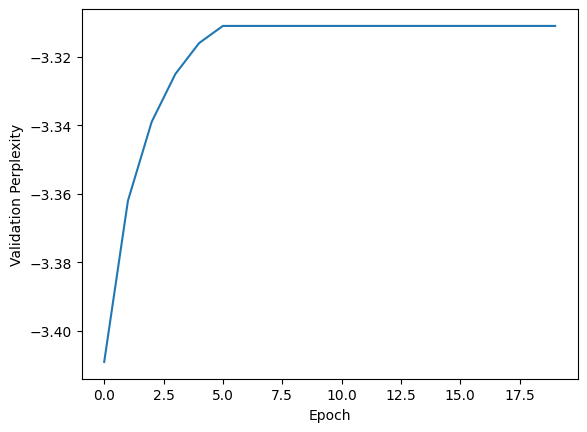

In [ ]:
## numbers copy and pasted from the output of the above cell for learning rate 0.001 and tau = 100
## these may change slightly, from iteration to iteration

best_val_perplex = [-3.408, -3.363, -3.340, -3.326, -3.318] + [-3.314] * 15
plt.plot(range(len(best_val_perplex)), best_val_perplex)
plt.xlabel('Epoch')
plt.ylabel('Validation Perplexity')
plt.show()

## The following cell runs the model on the testing data to return log likelihoods, perplexities, etc. This is done for the best validation perplexity model.

In [ ]:
## testing values

trainer.test(pl_model[3], dataloaders['test'], verbose=False)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_all/loglik/anger': -3.9481265544891357,
  'test_all/loglik/fear': -2.970546007156372,
  'test_all/loglik/joy': -3.2067947387695312,
  'test_all/loglik/sadness': -3.046985149383545,
  'test_all/loglik/surprise': -3.2329049110412598,
  'test/loglik': -3.280585765838623,
  'test/perplexity': 27.61029052734375,
  'test/loss': 7953.18798828125,
  'test_all/loglik/love': -3.0723683834075928}]

## Plot time ...

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## import the log files from the previous part somehow

!pip install tbparse

In [ ]:
from tbparse import SummaryReader
import seaborn as sns

def build_dataset_of_dataset_sizes():
    # Gathered from the dataloader but pasted here for convenience
    task_stats = {'anger': {'train_len': 490, 'val_len': 246, 'test_len': 245},
                  'fear': {'train_len': 126, 'val_len': 63, 'test_len': 63},
                  'joy': {'train_len': 934, 'val_len': 468, 'test_len': 467},
                  'love': {'train_len': 126, 'val_len': 62, 'test_len': 63},
                  'sadness': {'train_len': 765, 'val_len': 382, 'test_len': 383},
                  'surprise': {'train_len': 25, 'val_len': 12, 'test_len': 13}}
    dataset_sizes = pd.DataFrame([{'task' : key, 'dataset_size' : val['train_len']} for key, val in task_stats.items()])
    return dataset_sizes

In [ ]:
def get_val_perplex_per_task(experiment_id):
    log_dir = f"logs/{experiment_id}"
    reader = SummaryReader(log_dir)
    df = reader.scalars

    # Check if tag column contains "val_all/perplexity"
    val_all = df[df["tag"].str.contains("val_all")]
    val_all['task'] = val_all['tag'].str.extract(r'val_all/loglik/(.*)')

    # Group by task and get the maximum value of the value column
    val_all_max = val_all.groupby('task')['value'].max()
    # Combine val_all_max with experiment ID into a dataframe
    df = pd.DataFrame(val_all_max).reset_index()
    df['val_perplexity'] = np.exp(-df['value'])
    df['experiment_id'] = experiment_id
    return df


def get_val_perplexity_for_all_tasks(main_results):
    loglik_pds = []
    for experiment_id in main_results["experiment_id"]:
        loglik_pds.append(get_val_perplex_per_task(experiment_id))

    # Concat all df_task_perplexity into one dataframe
    df_task_perplexity = pd.concat(loglik_pds)[['task','val_perplexity','experiment_id']]
    # pivot the dataframe to experiments and tasks
    task_pivot = df_task_perplexity.pivot(index="experiment_id", columns="task", values="val_perplexity")
    df = task_pivot.merge(main_results, on="experiment_id")
    return df_task_perplexity, df

In [ ]:
values = [(0, 10 ** -4), (10 ** 0, 10 ** -5), (10 ** 1, 10 ** -4), (10 ** 2, 10 ** -3), (10 ** 3, 10 ** -2), (10 ** 4, 10 ** -1)]
main_results = []
for i, vals in enumerate(values):
  exp_name = "reg:"+str(vals[0])+"-lr:"+str(vals[1])
  main_results.append([vals[1], vals[0], None, exp_name])

main_results = pd.DataFrame(main_results, columns = ['lr', 'tau', 'validation perplexity', 'experiment_id'])
main_results

,lr,tau,validation perplexity,experiment_id
0,0.0001,0,None,reg:0-lr:0.0001
1,0.0010,100,None,reg:100-lr:0.001
2,0.1000,10000,None,reg:10000-lr:0.1


In [ ]:
### ###
### Precompute values
### ### ###

df_task_val_perplexity, df_val = get_val_perplexity_for_all_tasks(main_results)
dataset_sizes = build_dataset_of_dataset_sizes()
tasks = df_task_val_perplexity['task'].unique()

cm=1/2.54
sns.set_theme(
    style='ticks',
    rc={'figure.figsize':(2*8.5*cm, 8.5*cm),
    'font.size': 8.5, 'axes.titlesize': 8, 'axes.labelsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8}
    )

<ipython-input-25-57726410>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_all['task'] = val_all['tag'].str.extract(r'val_all/loglik/(.*)')
<ipython-input-25-57726410>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_all['task'] = val_all['tag'].str.extract(r'val_all/loglik/(.*)')
<ipython-input-25-57726410>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [ ]:
### ###
### Generate latex table with main result with the validation perplexity
### ### ###

main_results['validation perplexity'] = [29.62957527,  34.89976139,  28.73882921,  27.77544872, 29.05788997, 652.65722933]
# values from average validation perplexity across tasks, see df_val

df_main_results = pd.DataFrame(main_results)

# Define formatters
min_val_perplexity = df_main_results['validation perplexity'].min()

formatters = {
    'lr': lambda x: '$10^{{{}}}$'.format(int(np.log10(x))) if x != 0 else '0',
    'tau': lambda x: '$10^{{{}}}$'.format(int(np.log10(x))) if x != 0 else '0',
    'validation perplexity': lambda x: '\\textbf{{{:.2f}}}'.format(x) if x == min_val_perplexity else '{:.2f}'.format(x)
}
# remove experiment_id
df_main_results = df_main_results.drop(columns=['experiment_id'])


# Print DataFrame as LaTeX table with formatters
print(df_main_results.to_latex(index=False, formatters=formatters, escape=False))

ValueError: Length of values (6) does not match length of index (3)

In [ ]:
### ###
# Plot relative test improvements from the validation perplexity
# Do this by merging the datasets and plotting them with different color and scatter markers
### ### ###

best_experiment_id = "reg:100-lr:0.001"
best_model = df_task_val_perplexity[df_task_val_perplexity['experiment_id'] == best_experiment_id].sort_values("task")

separate_model = df_task_val_perplexity[df_task_val_perplexity['experiment_id'] == "reg:0-lr:0.0001"].sort_values("task")
one_model = df_task_val_perplexity[df_task_val_perplexity['experiment_id'] == "reg:10000-lr:0.1"].sort_values("task")

improvement_separate = (1-best_model['val_perplexity']/separate_model['val_perplexity'])*100
improvement_one = (1-best_model['val_perplexity']/one_model['val_perplexity'])*100

task_size_vs_improvement = pd.DataFrame({
    'task': best_model['task'],
    'improvement_separate': improvement_separate,
    'improvement_one': improvement_one
    }).merge(dataset_sizes, left_on='task', right_on='task')

# Plot improvement_separate
plt.scatter(task_size_vs_improvement['dataset_size'], task_size_vs_improvement['improvement_separate'],
            color='b', marker='o', label='Improvement from separate models ($\\tau=0$)')

# Plot improvement_one
plt.scatter(task_size_vs_improvement['dataset_size'], task_size_vs_improvement['improvement_one'],
            color='r', marker='x', label='Improvement from one model ($\\tau=10000$)')

plt.xlabel('Training data size')
plt.ylabel('Rel Improvement Perplexity [%]')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, shadow=False, ncol=2)

# plt.savefig('figures/relative_improvement_combined.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()